In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from itertools import izip
import tensorflow as tf
from tf_vgg.kaggle_data import *
from tf_vgg import vgg16_bw, utils, vgg16
import matplotlib.pyplot as plt



In [2]:
lungs = get_training_lungs()
labels = get_training_lung_labels()

In [3]:
for tup,label in izip(lungs, labels):
    print tup[0].shape
    print tup[1]
    print label
    break
    

(60, 224, 224)
059d8c14b2256a2ba4e38ac511700203
1


### TEST VGG-BW

In [4]:
VGG_DIR = "/notebooks/sharedfolder/lungcancerdl/tf_vgg/"
VGG16_WEIGHT = VGG_DIR+"vgg16.npy"
nn_weights = np.load(VGG16_WEIGHT, encoding='latin1').item()

In [5]:
for k in nn_weights:
    print k, nn_weights[k][0].shape, nn_weights[k][1].shape

conv5_1 (3, 3, 512, 512) (512,)
fc6 (25088, 4096) (4096,)
conv5_3 (3, 3, 512, 512) (512,)
fc7 (4096, 4096) (4096,)
fc8 (4096, 1000) (1000,)
conv5_2 (3, 3, 512, 512) (512,)
conv4_1 (3, 3, 256, 512) (512,)
conv4_2 (3, 3, 512, 512) (512,)
conv4_3 (3, 3, 512, 512) (512,)
conv3_3 (3, 3, 256, 256) (256,)
conv3_2 (3, 3, 256, 256) (256,)
conv3_1 (3, 3, 128, 256) (256,)
conv1_1 (3, 3, 3, 64) (64,)
conv1_2 (3, 3, 64, 64) (64,)
conv2_2 (3, 3, 128, 128) (128,)
conv2_1 (3, 3, 64, 128) (128,)


### Convert conv1_1 to black and white by summing across channels

In [6]:
w,b = nn_weights['conv1_1']
print w.shape, b.shape

(3, 3, 3, 64) (64,)


In [7]:
w,b = nn_weights['conv1_1']
w1= w[:,:,:,0]
print w1
print np.sum(w1, axis=2)






[[[ 0.42947057  0.55037946  0.4800154 ]
  [ 0.373467    0.44007453  0.4085474 ]
  [-0.06136011 -0.08138704 -0.06514555]]

 [[ 0.27476987  0.34573907  0.31047726]
  [ 0.03868078  0.04063221  0.05020237]
  [-0.36722335 -0.45350131 -0.40338343]]

 [[-0.05746817 -0.05863491 -0.05087169]
  [-0.26224968 -0.33066967 -0.28522751]
  [-0.35009676 -0.4850302  -0.41851634]]]
[[ 1.45986545  1.22208893 -0.2078927 ]
 [ 0.93098617  0.12951535 -1.2241081 ]
 [-0.16697477 -0.87814689 -1.25364327]]


Notice that conv1_1's weight tensor is 4d, 
there are 64, 3 by 3 by 3 convolutions....
So lets sum up the color channels

Notice that we do not have to change the bias parameter...

w(x - m) => wx - wm

So we have to subtract weight * mean for each channel to the bias term!

In [8]:
#one conv
b_mean, g_mean, r_mean = [103.939, 116.779, 123.68]
w1 = w[:,:,:,0]
b1 = b[0]
print w1
b1_x = np.sum(w1[:,:,0] * b_mean) + np.sum(w1[:,:,1] * g_mean) + np.sum(w1[:,:,2] * r_mean)
print b1_x

mult_mat = np.zeros_like(w1)
mult_mat[:,:,0] = b_mean
mult_mat[:,:,1] = g_mean
mult_mat[:,:,2] = r_mean
print np.sum(w1 * mult_mat)

[[[ 0.42947057  0.55037946  0.4800154 ]
  [ 0.373467    0.44007453  0.4085474 ]
  [-0.06136011 -0.08138704 -0.06514555]]

 [[ 0.27476987  0.34573907  0.31047726]
  [ 0.03868078  0.04063221  0.05020237]
  [-0.36722335 -0.45350131 -0.40338343]]

 [[-0.05746817 -0.05863491 -0.05087169]
  [-0.26224968 -0.33066967 -0.28522751]
  [-0.35009676 -0.4850302  -0.41851634]]]
1.31425
1.31426


In [9]:
w,b = nn_weights['conv1_1']
print w.shape, b.shape
b_mean, g_mean, r_mean = [103.939, 116.779, 123.68]
mult_mat = np.zeros_like(w)
mult_mat[:,:,0,:] = b_mean
mult_mat[:,:,1,:] = g_mean
mult_mat[:,:,2,:] = r_mean
w_copy = w * mult_mat

print w_copy.shape
bias_extra = np.sum(w_copy, axis=(2, 0, 1))
print bias_extra.shape
w = np.sum(w, axis=2, keepdims=True)
b -= bias_extra
print w.shape
print bias_extra[0]

(3, 3, 3, 64) (64,)
(3, 3, 3, 64)
(64,)
(3, 3, 1, 64)
1.31429


In [10]:
#print bias_extra - bxx

In [11]:
nn_weights['conv1_1'][0] = w
nn_weights['conv1_1'][1] = b


for k in nn_weights:
    print k, nn_weights[k][0].shape, nn_weights[k][1].shape
np.save(VGG_DIR + "vgg16_bw.npy", nn_weights)

conv5_1 (3, 3, 512, 512) (512,)
fc6 (25088, 4096) (4096,)
conv5_3 (3, 3, 512, 512) (512,)
fc7 (4096, 4096) (4096,)
fc8 (4096, 1000) (1000,)
conv5_2 (3, 3, 512, 512) (512,)
conv4_1 (3, 3, 256, 512) (512,)
conv4_2 (3, 3, 512, 512) (512,)
conv4_3 (3, 3, 512, 512) (512,)
conv3_3 (3, 3, 256, 256) (256,)
conv3_2 (3, 3, 256, 256) (256,)
conv3_1 (3, 3, 128, 256) (256,)
conv1_1 (3, 3, 1, 64) (64,)
conv1_2 (3, 3, 64, 64) (64,)
conv2_2 (3, 3, 128, 128) (128,)
conv2_1 (3, 3, 64, 128) (128,)


# Lets test it!!!
Load tiger and puzzle images, convert to bw and see if the thing works...

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


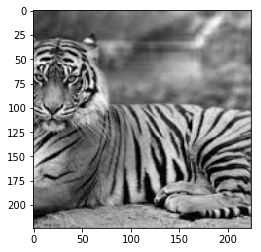

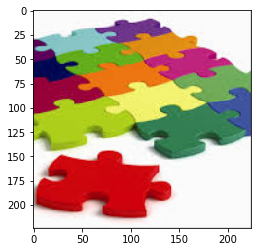

In [12]:
tiger = utils.load_image(VGG_DIR + "test_data/tiger.jpeg")
puzzle = utils.load_image(VGG_DIR + "test_data/puzzle.jpeg")

def show(img):
    if len (img.shape) < 3:
        plt.imshow(img, cmap=plt.cm.gray)
    else:
        plt.imshow(img)#, cmap=plt.cm.gray)
    plt.show()

show(tiger[:,:,1])
show(puzzle)

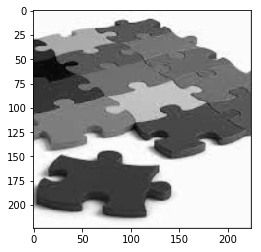

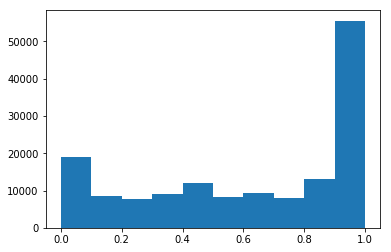

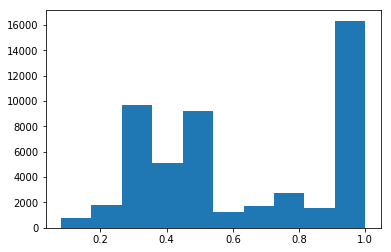

In [13]:
def make_bw(img):
    return np.mean(img, axis=2)
show(make_bw(puzzle))
plt.hist(puzzle.flatten())
plt.show()
plt.hist(make_bw(puzzle).flatten())
plt.show()

In [14]:
puzzle_bw, tiger_bw = make_bw(puzzle), make_bw(tiger)
batch1 = puzzle_bw.reshape((1, 224, 224, 1))
batch = tiger_bw.reshape((1, 224, 224, 1))

#batch = np.concatenate((batch1, batch2), 0)

with tf.device('/gpu:0'):
    with tf.Session() as sess:
        images = tf.placeholder("float", [1, 224, 224, 1])
        feed_dict = {images: batch}

        vgg = vgg16_bw.Vgg16_bw()
        with tf.name_scope("content_vgg"):
            vgg.build(images)

        prob = sess.run(vgg.prob, feed_dict=feed_dict)
        #print(prob)
        utils.print_prob(prob[0], VGG_DIR+'/synset.txt')
        #utils.print_prob(prob[1], VGG_DIR+'/synset.txt')

/notebooks/sharedfolder/lungcancerdl/tf_vgg/vgg16_bw.npy
npy file loaded
build model started
build model finished: 0s
('Top1: ', 'n02129604 tiger, Panthera tigris', 0.83637726)
('Top5: ', [('n02129604 tiger, Panthera tigris', 0.83637726), ('n02123159 tiger cat', 0.15142864), ('n02128925 jaguar, panther, Panthera onca, Felis onca', 0.0082249446), ('n02123045 tabby, tabby cat', 0.00095470145), ('n02128757 snow leopard, ounce, Panthera uncia', 0.00087960617)])


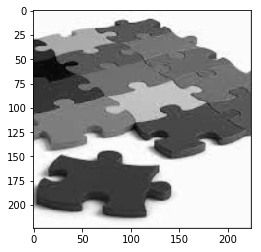

In [15]:
show(batch1.reshape((224,224)))

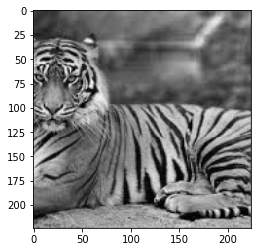

In [16]:
bwtiger = np.zeros((224,224,3))
bwtiger[:, :, 0] += tiger_bw[:]
bwtiger[:, :, 1] += tiger_bw[:]
bwtiger[:, :, 2] += tiger_bw[:]
show(bwtiger)

In [17]:


batch1 = bwtiger.reshape((1, 224, 224, 3))

# with tf.Session(config=tf.ConfigProto(gpu_options=(tf.GPUOptions(per_process_gpu_memory_fraction=0.7)))) as sess:
with tf.device('/gpu:0'):
    with tf.Session() as sess:
        images = tf.placeholder("float", [1, 224, 224, 3])
        feed_dict = {images: batch1}

        vgg = vgg16.Vgg16()
        with tf.name_scope("content_vgg"):
            vgg.build(images)
        prob = sess.run(vgg.prob, feed_dict=feed_dict)
        #print(prob)
        utils.print_prob(prob[0], VGG_DIR+'/synset.txt')


/notebooks/sharedfolder/lungcancerdl/tf_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
('Top1: ', 'n02129604 tiger, Panthera tigris', 0.84362137)
('Top5: ', [('n02129604 tiger, Panthera tigris', 0.84362137), ('n02123159 tiger cat', 0.14411561), ('n02128925 jaguar, panther, Panthera onca, Felis onca', 0.0076911184), ('n02123045 tabby, tabby cat', 0.0010678095), ('n02128757 snow leopard, ounce, Panthera uncia', 0.00092157919)])


### well great... none of that worked....

In [5]:
lungs = get_training_lungs()
lung = None
feats = None
for l, lung_id in lungs:
    lung = l.reshape((60,224,224,1))
    break
with tf.device('gpu:0'):
    with tf.Session() as sess:
        images = tf.placeholder("float", [60, 224, 224, 1])

        vgg = vgg16_bw.Vgg16_bw()
        with tf.name_scope("content_vgg"):
            vgg.build(images)
            
        for l, lung_id in lungs:
            lung = l.reshape((60,224,224,1))
            feed_dict = {images: lung}
            feats = sess.run(vgg.pool5, feed_dict=feed_dict)
            print(feats.shape)
    

/notebooks/sharedfolder/lungcancerdl/tf_vgg/vgg16_bw.npy
npy file loaded
build model started
build model finished: 0s
(60, 7, 7, 512)
(60, 7, 7, 512)
(60, 7, 7, 512)
(60, 7, 7, 512)
(60, 7, 7, 512)
(60, 7, 7, 512)
(60, 7, 7, 512)
(60, 7, 7, 512)
(60, 7, 7, 512)
(60, 7, 7, 512)


KeyboardInterrupt: 